In [249]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

In [93]:
class Propagator_Dataset(Dataset):
    
    def __init__(self, data, targets, total_data = 19800, transform=True):
        
        self.data = data
        self.targets = targets
        self.transform = transform
        self.total_data = total_data
        
    def __getitem__(self, index):
        
        total_data = self.total_data  # 198 data by file, 1000 files(from 0 to 999), total data: 198*100 = 19800
        
        if index > total_data:
            print("Error, this data does not exist")
        else:
            index_data = (index//199)%199  # because there 198 data per file
            index_t = (index-199)%199
            
            # Input data: Wavepacket real and imaginary part + Potential at time t
            x_r = (np.load(self.data+str(index_data)+'/Wavepacket/'+str(index_t)+'-wave.npy')).real
            x_i = (np.load(self.data+str(index_data)+'/Wavepacket/'+str(index_t)+'-wave.npy')).imag
            x_p = np.load(self.data+str(index_data)+'/Potential/'+str(index_t)+'-potential.npy')
            # Output data: Wavepacket real and imaginary part at time t+1*step
            y_r = (np.load(self.targets+str(index_data)+'/Wavepacket/'+str(index_t+1)+'-wave.npy')).real
            y_i = (np.load(self.targets+str(index_data)+'/Wavepacket/'+str(index_t+1)+'-wave.npy')).imag
        
            x = np.concatenate((x_r, x_i, x_p))  # flat array form

            y = np.concatenate((y_r, y_i))  # flat array form
        
            if self.transform:
                x = torch.from_numpy(x)
                y = torch.from_numpy(y)
        
            return x, y
    
    def __len__(self):
        
        
        return self.total_data



In [94]:
dataset = Propagator_Dataset(data='../../Data_Gaussian/data', targets='../../Data_Gaussian/data', transform=True)
batch_size = 16
validation_split = .1  #9:1 ratio
shuffle_dataset = True
random_seed= 42

In [95]:
dataset_size = len(dataset)
print('Total de datos: ', dataset_size)



Total de datos:  19800


In [96]:
# Creating data indices for training and validation splits:
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)



In [97]:
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

In [163]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [278]:
for X, y in validation_loader:
    #print(f"Shape of X [N, C, H, W]: {X.shape}")
    #print(f"Shape of y: {y.shape} {y.dtype}")
    #print(f"\nmuestra de un batch:\n", X)
    #print(f"\nmuestra de un batch parte real:\n", X[:,0:32])
    #print(f"\nmuestra de un batch parte imag:\n", X[:,32:64])
    #print(f"\n\n Parte real e imag:", torch.cat((X[:,0:32],X[:,32:64]),1).shape)
    
    #print(f"\nmuestra de un batch parte real:\n", X[0,0:32])
    #print(f"\nmuestra de un batch parte imag:\n", X[0,32:64])
    a = torch.view_as_complex(torch.stack((X[0,0:32],X[0,32:64]), -1))
    b = torch.view_as_complex(torch.stack((X[1,0:32],X[1,32:64]), -1))
    print(f"\n\n Parte real e imag:\n", a)
    print(f"\n\n Parte real e imag:\n", b)
    prueba = []
    for i in range(32):
        prueba.append(torch.tensor([a[i]*b[i]]))
        
    print((torch.tensor(prueba).imag).numpy())
    print(f"\n\n multiplicacion:", torch.matmul(a,b))
    break

    
   



 Parte real e imag:
 tensor([-8.7661e-11+2.1148e-09j,  8.1051e-05+4.3326e-04j,
        -5.7365e-05-9.5819e-04j,  2.0502e-04+1.5007e-03j,
        -9.6248e-05-2.0590e-03j,  1.0534e-03+3.7450e-03j,
        -2.2863e-03-4.9139e-03j, -2.8312e-03+5.3269e-03j,
        -1.4290e-04-6.8579e-03j,  3.6966e-03+1.1966e-02j,
        -9.4212e-05-2.4247e-02j,  4.6003e-03-6.0915e-02j,
         4.3763e-02-3.2299e-01j,  1.9723e-01-3.6082e-01j,
         2.0322e-01-2.5784e-01j,  3.1144e-01-4.0675e-02j,
         7.8671e-01-1.3906e-01j,  1.1477e+00+1.2916e-01j,
         8.7577e-01+4.3778e-01j,  5.4112e-01+7.3656e-01j,
         6.0376e-01+6.1728e-01j,  5.4036e-01+3.5710e-01j,
         2.0810e-01+4.6801e-02j,  3.7933e-02+4.4262e-02j,
        -2.6042e-03+2.1531e-02j,  4.9427e-03+3.2363e-02j,
        -1.4618e-03+8.6240e-04j, -5.2431e-04+6.7269e-03j,
        -5.9739e-04-4.8025e-03j, -1.4643e-03+2.8804e-03j,
        -1.0007e-03-1.3959e-03j,  2.2864e-06+1.4051e-06j],
       dtype=torch.complex128)


 Parte real e i

In [99]:
device = "cpu"
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(96, 1024),
            nn.ReLU(),
            nn.ReLU(),
            nn.ReLU(),
            nn.Linear(1024, 64)
        )
        
    def forward(self, x):
        return self.layers(x)

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=96, out_features=1024, bias=True)
    (1): ReLU()
    (2): ReLU()
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=64, bias=True)
  )
)


In [100]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [101]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X.float())
        loss = loss_fn(pred, y.float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [293]:
def S_overlap(Psi_true, Psi_ANN):
    """
    Input:
    Psi_true: Evolution of wavepacket from dataset test
    Psi_ANN: Evolution of wavepacket predicted with the model
    
    Output:
    S: Absolute magnitude
    angle: phase
    Characterizes the quality of the predictions. See equation (11) of Main article
    
    """
    
    Psi_true_re = Psi_true[:,0:32]  # real part of wavepacket
    Psi_true_im = Psi_true[:,32:64]  # imaginary part of wavepacket
    Psi_t = torch.view_as_complex(torch.stack((Psi_true_re,Psi_true_im), -1))
    
    
    Psi_ANN_re = Psi_ANN[:,0:32]  # realpart of wavepacket predicted
    Psi_ANN_im = -Psi_ANN[:,32:64]  # imaginary part of wavepacket predicted (- because conjugate)
    Psi_A = torch.view_as_complex(torch.stack((Psi_ANN_re,Psi_ANN_im), -1))
    
    S_tot = []
    angle_tot = []
    for j in range(batch_size):
        overlap = []
        for i in range(32):
            overlap.append(torch.tensor([Psi_A[j,i]*Psi_t[j,i]]))
        overl = torch.tensor(overlap)
        
        # Integrate over r (real integral + complex integral)
        # Simpson method in the grid r_n (angstroms -> au)
        r_n = np.linspace(-1.5,1.5,32)*(1/0.5291775)
        overl_real = overl.real.numpy()
        overl_imag = overl.imag.numpy()
    
        real_integ = integrate.simpson(overl_real, r_n)
        imag_integ = integrate.simpson(overl_imag, r_n)
    
        # Covert to phase and magnitude of the complex result
        S_tot.append(np.sqrt(real_integ**2 + imag_integ**2))
        angle_tot.append(np.arctan(imag_integ/real_integ))
        
    S = sum(S_tot)*batch_size
    angle = sum(angle_tot)*batch_size
    
    return S, angle
    
    
    
    
    
    

In [294]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    
    #S_list = []
    phase_list = []
    with torch.no_grad():
        for X, y in dataloader:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            S, angle = S_overlap(y, pred)  # Accuracy by equation (11) Main Article
            #S_list.append(S)
            phase_list.append(angle)
                   
            correct += S
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [295]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(validation_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.066753  [    0/19800]
loss: 0.070176  [ 1600/19800]
loss: 0.067936  [ 3200/19800]
loss: 0.064789  [ 4800/19800]
loss: 0.064215  [ 6400/19800]
loss: 0.073482  [ 8000/19800]
loss: 0.066177  [ 9600/19800]
loss: 0.066449  [11200/19800]
loss: 0.061758  [12800/19800]
loss: 0.069361  [14400/19800]
loss: 0.060303  [16000/19800]
loss: 0.067573  [17600/19800]
Test Error: 
 Accuracy: 13.7%, Avg loss: 0.067577 

Epoch 2
-------------------------------
loss: 0.067271  [    0/19800]
loss: 0.074274  [ 1600/19800]
loss: 0.063896  [ 3200/19800]
loss: 0.076873  [ 4800/19800]
loss: 0.077533  [ 6400/19800]
loss: 0.077634  [ 8000/19800]
loss: 0.066364  [ 9600/19800]
loss: 0.071572  [11200/19800]
loss: 0.077043  [12800/19800]
loss: 0.070274  [14400/19800]
loss: 0.058527  [16000/19800]
loss: 0.070223  [17600/19800]
Test Error: 
 Accuracy: 13.9%, Avg loss: 0.067393 

Epoch 3
-------------------------------
loss: 0.058148  [    0/19800]
loss: 0.066741  [ 1600/198

## Inference

In [106]:
# Nota : Crear datos nuevos gaussianos

X1 = np.load("../../Data_Test/data_test0/Wavepacket/0-wave.npy")
X1p = np.load("../../Data_Test/data_test0/Potential/0-potential.npy")

Y1 = np.load("../../Data_Test/data_test0/Wavepacket/1-wave.npy")


X1_t = np.concatenate((X1.real,X1.imag, X1p))
Y1_t = np.concatenate((Y1.real, Y1.imag))



In [107]:
y1_pred = model(torch.from_numpy(X1_t).float())

In [108]:
y1_pred

tensor([ 0.0106,  0.0017,  0.0703, -0.0201, -0.0005, -0.0042,  0.0202, -0.0696,
        -0.0741,  0.0551, -0.0119, -0.0725, -0.0202, -0.0118,  0.0874,  0.0404,
         0.0610, -0.0615,  0.0387, -0.0162, -0.0304,  0.0092, -0.0300, -0.0081,
        -0.0661,  0.0159, -0.0139, -0.0535, -0.0779,  0.0864, -0.0050, -0.0044,
        -0.0139, -0.0046,  0.0536, -0.0701,  0.0788, -0.0506, -0.0038, -0.0738,
         0.0263, -0.1217, -0.0156,  0.0027,  0.1448,  0.0521,  0.1023, -0.0009,
         0.0915,  0.0320,  0.1352,  0.0044,  0.0516,  0.0773,  0.0538,  0.0437,
         0.0631, -0.0149,  0.0580, -0.0586, -0.0058,  0.0359,  0.0220, -0.0012],
       grad_fn=<AddBackward0>)

In [68]:
y1_pred1 = torch.tensor([-0.0166,  0.0346, -0.0005,  0.0188,  0.0619,  0.0856,  0.1002,  0.0796,
         0.0334,  0.0226, -0.0359, -0.0084,  0.0503,  0.0580,  0.0692,  0.0178,
         0.0141,  0.0503,  0.0331,  0.0371,  0.0193, -0.0240, -0.0067, -0.0662,
         0.0392,  0.0461,  0.0179,  0.0103, -0.0258, -0.0050,  0.0748, -0.0099,
         0.0242, -0.0081, -0.0366, -0.0128,  0.0166, -0.0467,  0.0156,  0.0529,
         0.0618,  0.0320,  0.0029,  0.0386, -0.0745,  0.0592,  0.0810,  0.0839,
         0.0351,  0.0059,  0.0264,  0.0072,  0.0178,  0.0476, -0.0012,  0.0869,
         0.0023,  0.0960,  0.0039,  0.0224, -0.0173,  0.0321, -0.0770,  0.0133], requires_grad=True)

In [109]:
y1_r = [ 0.0106,  0.0017,  0.0703, -0.0201, -0.0005, -0.0042,  0.0202, -0.0696,
        -0.0741,  0.0551, -0.0119, -0.0725, -0.0202, -0.0118,  0.0874,  0.0404,
         0.0610, -0.0615,  0.0387, -0.0162, -0.0304,  0.0092, -0.0300, -0.0081,
        -0.0661,  0.0159, -0.0139, -0.0535, -0.0779,  0.0864, -0.0050, -0.0044]

In [110]:
y1_r = np.array(y1_r)

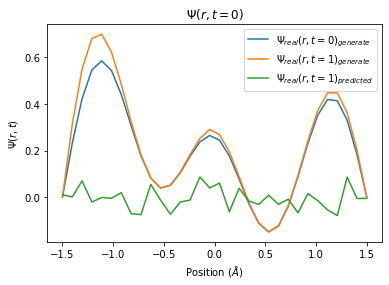

In [111]:
r_n = np.linspace(-1.5,1.5,32)
fig, ax = plt.subplots()
ax.set_title(r"$\Psi(r,t=0)$")
ax.set_xlabel('Position ($\AA$)')
ax.set_ylabel('$\Psi(r,t)$')

# Lenght: au -> Angstroms
ax.plot(r_n, X1.real, label="$\Psi_{real}(r, t=0)_{generate}$")
ax.plot(r_n, Y1.real, label="$\Psi_{real}(r, t=1)_{generate}$")

ax.plot(r_n, y1_r, label="$\Psi_{real}(r, t=1)_{predicted}$")

ax.legend()
plt.show()